In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
import pickle
from tensorflow.keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils


In [2]:
BATCH_SIZE = 63
IMAGE_SIZE = 256
EPOCHS=50
CHANNELS=3

In [3]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/Athithyaraagul/Code/Machine_Learning/Orcal-Cancer-Pic-Data/train",
    labels = "inferred",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 5192 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Normal', 'OSCC']

In [5]:
len(dataset)

83

In [6]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(63, 256, 256, 3)
tf.Tensor(
[[[227.25 245.75 247.5 ]
  [223.   244.75 250.25]
  [227.5  247.   246.  ]
  ...
  [215.   234.5  220.  ]
  [210.75 231.75 222.  ]
  [214.   233.   222.25]]

 [[232.75 246.5  249.25]
  [227.   244.25 246.  ]
  [223.75 245.   249.  ]
  ...
  [214.   234.   222.5 ]
  [212.25 236.25 223.25]
  [214.   231.25 220.75]]

 [[224.5  248.75 248.5 ]
  [228.25 249.25 253.25]
  [229.5  247.   251.25]
  ...
  [211.   231.   219.25]
  [211.75 233.75 219.75]
  [211.75 230.25 226.25]]

 ...

 [[155.75 161.25 202.25]
  [122.   136.5  188.  ]
  [127.   136.5  189.5 ]
  ...
  [133.75 135.   144.5 ]
  [154.5  157.75 181.  ]
  [125.   131.75 170.75]]

 [[170.75 175.   205.5 ]
  [ 83.25  99.25 146.25]
  [140.25 150.   195.  ]
  ...
  [ 20.75  55.5   99.5 ]
  [ 56.    76.75 116.25]
  [ 62.25  71.75 126.5 ]]

 [[113.25 118.75 177.  ]
  [ 59.5   72.75 143.5 ]
  [149.75 150.75 195.25]
  ...
  [170.75 180.   210.  ]
  [133.75 140.75 189.  ]
  [ 68.    88.25 142.5 ]]], shape=(256, 256,

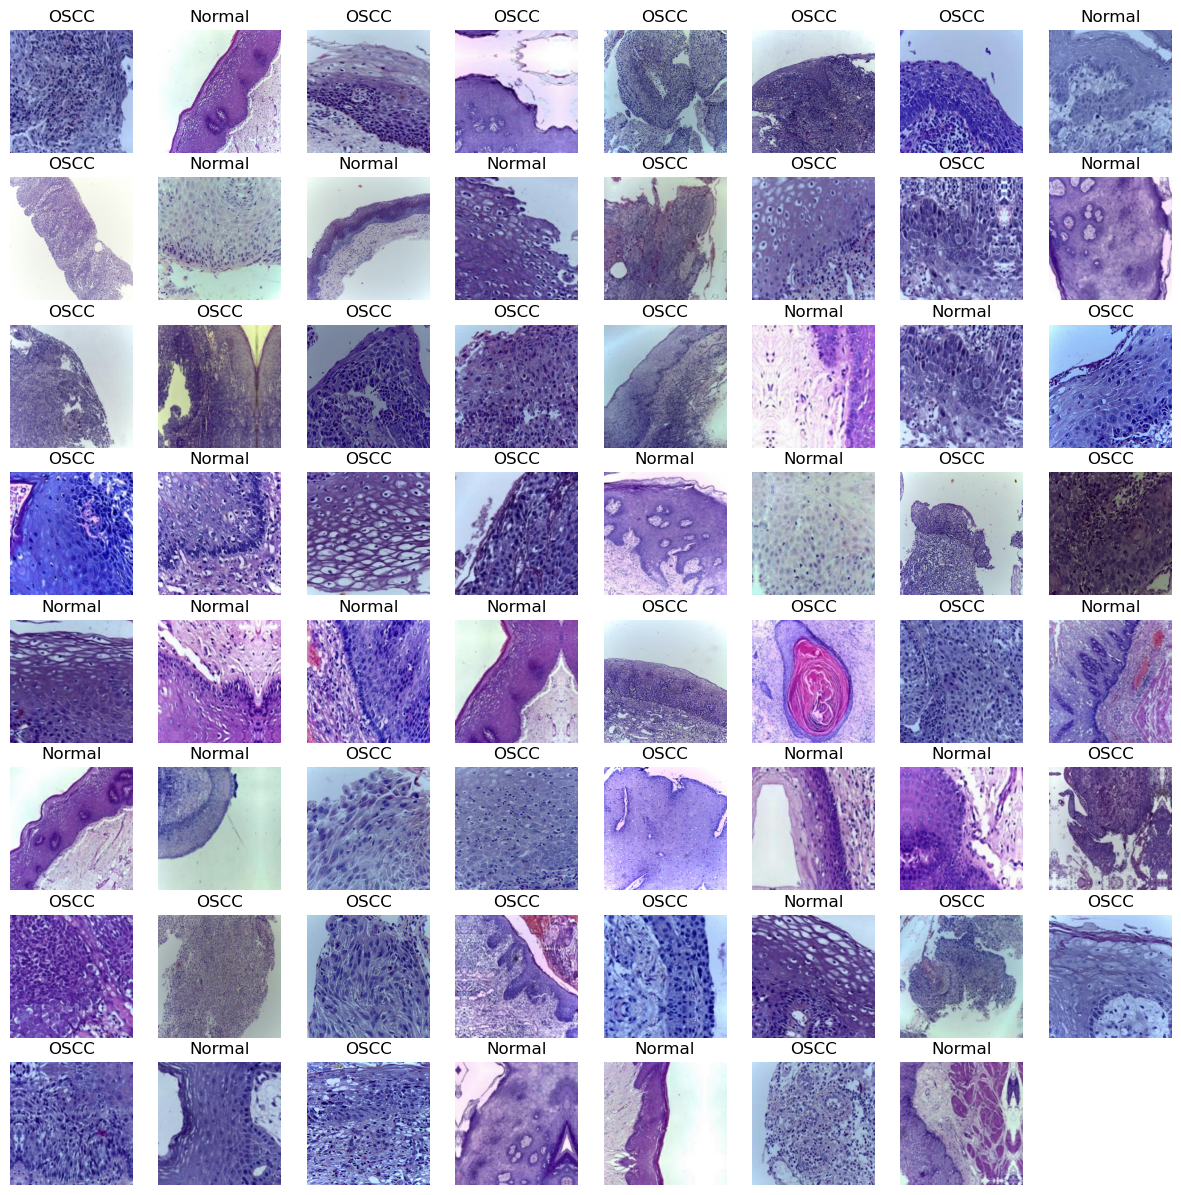

In [7]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

In [10]:
model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [11]:
model.summary()
# callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_accuracy',mode='max',verbose=1, save_best_only=True),
#              ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1, mode='max', min_lr=0.0000000001)]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (63, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (63, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (63, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (63, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (63, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (63, 60, 60, 64)         

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    # callbacks = callbacks
)

Epoch 1/50
66/66 [==============================] - 95s 654ms/step - loss: 0.7805 - accuracy: 0.5062 - val_loss: 0.6943 - val_accuracy: 0.5119
Epoch 2/50
66/66 [==============================] - 4s 66ms/step - loss: 0.6823 - accuracy: 0.5647 - val_loss: 0.6807 - val_accuracy: 0.5754
Epoch 3/50
66/66 [==============================] - 4s 67ms/step - loss: 0.6553 - accuracy: 0.6132 - val_loss: 0.7050 - val_accuracy: 0.5159
Epoch 4/50
66/66 [==============================] - 4s 67ms/step - loss: 0.6187 - accuracy: 0.6649 - val_loss: 0.6792 - val_accuracy: 0.5734
Epoch 5/50
66/66 [==============================] - 4s 65ms/step - loss: 0.6106 - accuracy: 0.6673 - val_loss: 0.6048 - val_accuracy: 0.6786
Epoch 6/50
66/66 [==============================] - 4s 65ms/step - loss: 0.5873 - accuracy: 0.6993 - val_loss: 0.6100 - val_accuracy: 0.6627
Epoch 7/50
66/66 [==============================] - 4s 66ms/step - loss: 0.5739 - accuracy: 0.7091 - val_loss: 0.5839 - val_accuracy: 0.7103
Epoch 8/50


In [13]:
model.evaluate(test_ds)

acc = history.history['accuracy']
loss = history.history['loss']

9/9 [==============================] - 36s 31ms/step - loss: 0.3016 - accuracy: 0.9224


In [14]:
model.save("Oral cancer detection.h5")

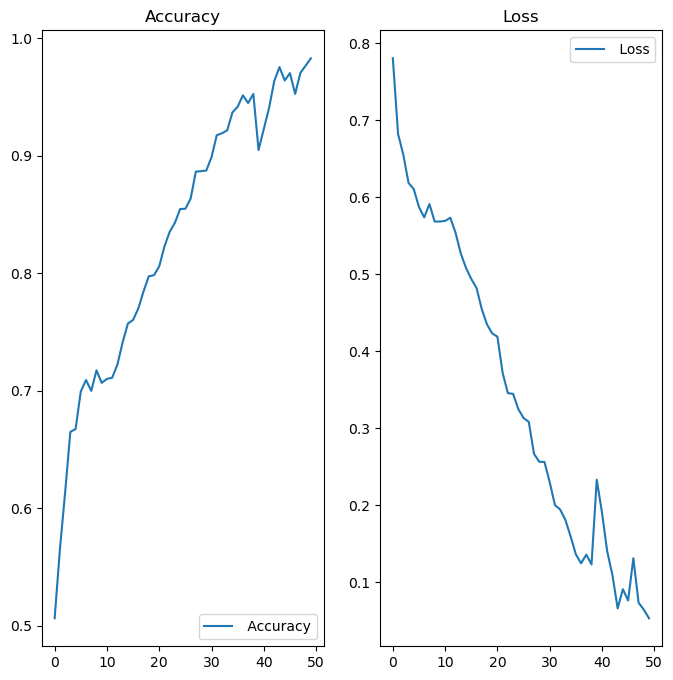

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [16]:
image_path = "/kaggle/input/data-life/data/OSCC/OSCC_100x_107.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

pred = model.predict(scaled_img)

output = class_names[np.argmax(pred)]

output



1/1 [==============================] - 0s 447ms/step


'OSCC'